In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
# load dataset
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [7]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [8]:
def plot_sample(index):
    plt.figure(figsize = (10,1))
    plt.imshow(X_train[index])

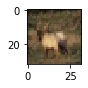

In [9]:
plot_sample(3)

In [11]:
# labels
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [12]:
classes[y_train[3][0]]

'deer'

In [13]:
# scaling
X_train_scaled= X_train / 255
X_test_scaled= X_test / 255

In [14]:
# Performing One Hot Encoding
# keras.utils.to_categorical convert classes to categorical values
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')

In [15]:
y_train_categorical[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [17]:
# Model
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='sigmoid')    
    ])

In [18]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 227s 117ms/step - loss: 1.8108 - accuracy: 0.3553
Epoch 2/10
1563/1563 [==============================] - 179s 115ms/step - loss: 1.6245 - accuracy: 0.4265
Epoch 3/10
1563/1563 [==============================] - 180s 115ms/step - loss: 1.5420 - accuracy: 0.4559
Epoch 4/10
1563/1563 [==============================] - 187s 120ms/step - loss: 1.4824 - accuracy: 0.4773
Epoch 5/10
1563/1563 [==============================] - 180s 115ms/step - loss: 1.4310 - accuracy: 0.4968
Epoch 6/10
1563/1563 [==============================] - 179s 115ms/step - loss: 1.3876 - accuracy: 0.5128
Epoch 7/10
1563/1563 [==============================] - 180s 115ms/step - loss: 1.3502 - accuracy: 0.5247
Epoch 8/10
1563/1563 [==============================] - 179s 115ms/step - loss: 1.3188 - accuracy: 0.5371
Epoch 9/10
1563/1563 [==============================] - 188s 120ms/step - loss: 1.2821 - accuracy: 0.5510
Epoch 10/10
1563/1563 [=======================

In [27]:
model.evaluate(X_test_scaled, y_test_categorical)

313/313 [==============================] - 8s 26ms/step - loss: 1.3474 - accuracy: 0.5203


[1.3473583459854126, 0.5202999711036682]

In [21]:
model.predict(X_test_scaled)[0]

array([0.41757664, 0.47151658, 0.6772915 , 0.8978871 , 0.59317166,
       0.82221746, 0.6398331 , 0.03139409, 0.45717973, 0.0906513 ],
      dtype=float32)

In [22]:
# finding maximum from prediction
np.argmax(model.predict(X_test_scaled)[0])

3

In [26]:
classes[np.argmax(model.predict(X_test_scaled)[0])]

'cat'

In [23]:
classes[y_test[0][0]]

'cat'

In [28]:
# custom NN model
def get_model():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32,3)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(10, activation='sigmoid')    
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
# converting numpy array to tf array
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_categorical))

In [30]:
type(train_tf_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [31]:
# tf MirroredStrategy 
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [32]:
# no of GPU if available or no of CPU
strategy.num_replicas_in_sync

1

In [33]:
BATCH_SIZE_PER_REPLICA = 250
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [34]:
train_dataset = train_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE)

In [37]:
# Measure training time on a CPU
%timeit -n1 -r1 
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 203s 129ms/step - loss: 1.8145 - accuracy: 0.3546


In [38]:
# Measure training time on a GPU
%%timeit -n1 -r1 
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

UsageError: Line magic function `%%timeit` not found.


In [39]:
# runnintg distributed training
%timeit -n1 -r1 
with strategy.scope():
    gpu_model = get_model()
    gpu_model.fit(train_dataset, epochs=1)

200/200 [==============================] - 62s 293ms/step - loss: 1.9872 - accuracy: 0.2967
